# Экономическая модель

## Загрузка данных

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, Imputer, StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.svm import LinearSVC
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
def load_data():
    train_df = pd.read_csv(r'orange_small_churn_train_data.csv', index_col='ID')
    test_df  = pd.read_csv(r'orange_small_churn_test_data.csv', index_col='ID')
    X = train_df.drop(['labels'], axis=1)
    y = train_df['labels'].apply(lambda x: 1 if x==1 else 0)

    X_train, X_hold, \
    y_train, y_hold = train_test_split(X, y,
                                       test_size=0.2,
                                       random_state=9,
                                       shuffle=True,
                                       stratify=y)
    X_test = test_df

    return X_train, X_hold, X_test, y_train, y_hold

## Вспомогательные функции, пайплайн

In [3]:
def get_pipeline(model,
                 missing='mean',
                 encoder='dummy', enc_params=None,
                 selector=None,   sel_params=None):

    # choose encoder

    enc_params = {} if enc_params is None else enc_params
    if encoder == 'dummy':
        encoder = DummyEncoder(**enc_params)
    elif encoder == 'mean_target':
        encoder = MeanTargetEncoder(**enc_params)
    elif encoder == 'frequency':
        encoder = FrequencyEncoder(**enc_params)
    else:
        encoder = NopeTransformer()

    # choose selector

    sel_params = {} if sel_params is None else sel_params
    if selector == 'lasso_svc':
        selector = LassoSelector(**sel_params)
    elif selector == 'correlation':
        selector = CorrelationSelector(**sel_params)
    else:
        selector = NopeTransformer()

    # construct pipeline

    pipeline = Pipeline(steps=[
            # preprocessing
            ('preprocessing', FeatureUnion([

                # numeric features
                ('numeric', Pipeline(steps=[
                    ('selecting',      FunctionTransformer(lambda data: data.iloc[:, :190], validate=False)),
                    ('float_nan_mean', Imputer(strategy=missing)),
                    ('scaling',        StandardScaler())
                ])),

                # categorical features
                ('categorical',   Pipeline(steps=[
                    ('selecting', FunctionTransformer(lambda data: data.iloc[:, 190:], validate=False)),
                    ('encoding',  encoder)
                ]))
            ])),

            # feature selection
            ('feature_selection', selector),

            # model
            ('model', model)
        ])

    return pipeline


class DummyEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features as one-hot variables with max_categories restriction
    '''
    def __init__(self, columns=None, max_categories=200):
        self.columns = columns
        self.dummy_columns = None
        self.max_categories = max_categories


    def fit(self, X, y=None, **kwargs):
        self.dummy_columns = None
        return self


    def transform(self, X, y=None, **kwargs):
        if self.max_categories is not None:
            X = X[self.columns] if self.columns is not None else X.copy()
            for col in X.columns:
                top_cats = X[col].value_counts()[:self.max_categories].index.values
                X[col] = X[col].apply(lambda x: x if (x in top_cats or x is None) else 'aggr')

        dummy_df = pd.get_dummies(X, columns=self.columns, sparse=True, dummy_na=True)
        new_cols = dummy_df.columns.values
        if self.dummy_columns is None:
            self.dummy_columns = new_cols
            return dummy_df
        else:
            res_df = pd.DataFrame()
            for col in self.dummy_columns:
                res_df[col] = dummy_df[col] if col in new_cols else np.zeros((len(X),), dtype=int)
        return res_df


class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features by its mean on target variable
    '''
    def __init__(self, columns=None):
        self.columns = columns
        self.dict = None
        return


    def fit(self, X, y=None, **kwargs):
        columns = X.columns if self.columns is None else self.columns
        dict = {}

        X = X.astype(str)

        for col in columns:
            vals = X[col].unique()
            dict[col] = { val: y[X[col] == val].mean() for val in vals }

        self.dict = dict

        return self


    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self, ['dict'])

        X = X.astype(str)
        columns = X.columns if self.columns is None else self.columns

        for col in columns:
            col_dict = self.dict[col]
            X[col] = X[col].apply(lambda x: col_dict.get(x, 0))

        return X


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features by its frequency
    '''
    def __init__(self, columns=None):
        self.columns = columns
        self.dict = None
        return


    def fit(self, X, y=None, **kwargs):
        columns = X.columns if self.columns is None else self.columns
        dict = {}

        X = X.astype(str)
        n = len(X)

        for col in columns:
            vals = X[col].unique()
            dict[col] = { val: (X[col] == val).sum()/n for val in vals }

        self.dict = dict

        return self


    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self, ['dict'])
        X = X.astype(str)
        columns = X.columns if self.columns is None else self.columns

        for col in columns:
            col_dict = self.dict[col]
            X[col] = X[col].apply(lambda x: col_dict.get(x, 0))

        return X


class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_top=100):
        self.n_top = n_top


    def fit(self, X, y=None):

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # 1. filter out const columns
        vc = X.apply(lambda col: len(col.value_counts()))
        all_cols = vc[vc > 1].index.values

        # 2. correlation feature selection
        num_corrs = X[all_cols].apply(lambda col: correlation(col.values, y), axis=0)
        top_corrs = num_corrs.abs().sort_values(ascending=False)[:self.n_top]

        self.new_cols = sorted(top_corrs.index)

        return self


    def transform(self, X):
        check_is_fitted(self, ['new_cols'])

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        return X.loc[:, self.new_cols]


class LassoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None, C=0.1):
        self.threshold = threshold
        self.C = C
        return


    def fit(self, X, y=None):
        model = LinearSVC(C=self.C, penalty='l1', dual=False)
        model.fit(X, y)
        self.selector = SelectFromModel(model, prefit=True, threshold=self.threshold)
        return self


    def transform(self, X):
        check_is_fitted(self, ['selector'])
        return self.selector.transform(X)


class NopeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


def filter_outliers(X, y, cols, alpha):
    print('filtering outliers...')
    for col in cols:
        var = X[col]
        var_churn = var[y==1]
        var_loyal = var[y==0]

        outliers = len(X)
        condition = None
        col_a = alpha

        while outliers > 200:
            churn_min, churn_max = var_churn.quantile([col_a, 1 - col_a])
            loyal_min, loyal_max = var_loyal.quantile([col_a, 1 - col_a])

            condition = var.isnull() | \
                        ((y==1) & (churn_min <= var) & (var <= churn_max)) | \
                        ((y==0) & (loyal_min <= var) & (var <= loyal_max))

            outliers = len(X) - len(X[condition])
            col_a /= 2

        if condition is not None:
            X = X[condition]
            y = y[condition]
    print('finished: ', len(X))

    return X, y


def undersample(X, y, coeff):

    np.random.seed(9)

    churn = X[y==1].index
    loyal = X[y==0].index.values
    np.random.shuffle(loyal)
    u_loyal = loyal[: int(coeff*len(loyal))]

    u_ids = list(churn) + list(u_loyal)

    return X.ix[u_ids, :], y.ix[u_ids]


def correlation(x, y):
    if set(np.unique(x)) == { 0.0, 1.0 }:
        return matthews_corrcoef(x, y)
    else:
        return point_biserial_corr(x, y)


def point_biserial_corr(x, y):
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    p = y.mean()
    q = 1 - p
    ex = x.mean()
    sx = x.std(ddof=0)

    px = x[y==1]
    nx = x[y==0]

    mpx = px.mean() if len(px)>0 else 0
    mnx = nx.mean() if len(nx)>0 else 0

    return (mpx - mnx)/sx*math.sqrt(p*q)

**Финальная модель:**
Модель с наилучшим качеством получается следующим образом:
- фильтрация выбросов
- 50% undersample-инг
- Заполнение пропущенных значений средним
- dummy-энкодинг категориальных переменных
- отбор признаков по корреляции с целевой переменной с максимальным числом признаков равным 30
- классификатог - XGBClassifier с n_estimators=120 и learning_rate=0.1

In [4]:
# load data
X_train, X_hold, X_test, y_train, y_hold = load_data()
X = pd.concat([X_train, X_hold], axis=0)
y = pd.concat([y_train, y_hold], axis=0)

# filter outliers
X_train, y_train = filter_outliers(X_train, y_train, X_train.columns[:190], 0.01)

# undersample
X_train, y_train = undersample(X_train, y_train, 0.5)

# model & pipeline
model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
pipeline = get_pipeline(model)

pipeline.fit(X, y)

y_pred = pipeline.predict_proba(X)[:, 1]
score = roc_auc_score(y, y_pred)

print(score)

filtering outliers...
finished:  25749


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:266: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.789260156773


# Экономическая модель

**Задание 1**

**Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.**

Будем исследовать экономический эффект, являющийся разностью полной прибыли после внедрения модели и прибыли без ее внедрения.
Введем следующие параметры:

$M$ - в среднем прибыли приносит один пользователь

$H$ - мы готовы потратить на удержание одного пользователя

$p$ - вероятность пользователю, собирающемуся уйти, принять наши условия и остаться

$g$ - доля TOP польнователей, склонных согласно нашему алгоритму уйти, участвующих в программе по удержанию. Фактически эту величину можно считать порогом алгоритма (threshold), выше которого его значения проецируются в 1, ниже - в 0

$T$ - полный бюджет кампании, который мы не должны превысить

Вся выборка пользователей разделяется на 4 части:

$TP$ - пользователи, которые собираются уйти согласно нашему алгоритму и в действительности

$FP$ - пользователи, которые собираются уйти согласно нашему алгоритму, но не в действительности

$TN$ - пользователи, которые не собираются уйти согласно нашему алгоритму, и в действительности

$FN$ - пользователи, которые не собираются уйти согласно нашему алгоритму, но не в действительности

Все величины &TP, FP, TN, FN& - функции параметра $g$

$TP$ часть

$p$ доля из них примет наши условия и останется, принеся в итоге $p \cdot TP \cdot (M - H)$, $1-p$ доля все равно уйдет, принеся убыток $-(1-p) \cdot TP \cdot H$. Если же не проводить кампанию ($g=0$), то прибыть от этой части пользователей составит 0.

В итоге вклад в экономический эффект от $TP$ пользователей составит

$$
L_{TP} = p \cdot TP \cdot (M - H) - (1-p) \cdot TP \cdot H = TP \cdot (p \cdot M - H)
$$

$FP$ часть

На $p$ долю мы ошибочно потратимся, и они в итоге принесут $p \cdot FP (M - H)$. Доля $1-p$ останется и принесет как обычно $(1-p) \cdot FP \cdot M$. Если не проводить кампанию, то прибыль от этой части пользователей составит $FP \cdot M$.

В итоге, вклад в экономический эффект от $FP$ пользователей составит

$$
L_{FP} = p \cdot FP (M - H) + (1-p) \cdot FP \cdot M - FP \cdot M = - p \cdot FP \cdot H
$$

$TN$ часть

Эти пользователи точно останутся и принесут $TN \cdot M$ денег. Эффект от кампании на них = 0:

$$
L_{TN} = 0
$$

$FN$ часть

Это пользователи, которые уйдут, но алгоритм этого не понял. Они принесут 0 денег. Эффект откампании тоже составит для них 0:

$$
L_{FN} = 0
$$

Итого, полный экономический эффект:

$$
L = L_{TP} + L_{FP} + L_{TN} + L_{FN} = TP(g) \cdot (p \cdot M - H)  - p \cdot FP(g) \cdot H
$$

При условии не превышении полного бюджета кампании:

$$
(TP(g) + p \cdot FP(g)) \cdot H \leqslant T
$$

Таким образом, постановка задачи на максимизацию экономического эффекта имеет вид:

$$
TP(g) \cdot (p \cdot M - H)  - p \cdot FP(g) \cdot H \rightarrow max,
$$

$$
(TP(g) + p \cdot FP(g)) \cdot H \leqslant T
$$

In [6]:
def check(TP_, FP_, p_, H_, T_):
    return (TP_ + p_*FP_)*H_ <= T_


def L(M_, H_, p_, g_, T_):
    threshold = np.percentile(y_pred, 100 - g_)
    a = (y_pred > threshold).astype(int)

    TP = ((y == 1) & (a == 1)).sum()
    FP = ((y == 0) & (a == 1)).sum()
    TN = ((y == 0) & (a == 0)).sum()
    FN = ((y == 1) & (a == 0)).sum()
    
    if not check(TP, FP, p, H, T):
        return None
    
    L = TP*(p_*M_ - H_) - p_*FP*H_
    
    return L

**Задание 2**

**Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?**

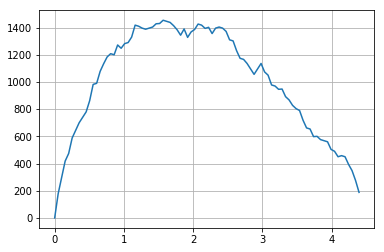

1.5656565656565655

In [8]:
M = 100
H = 20
p = 0.3
g = 1  # Top 1%
T = 20000

gs = np.linspace(0, 5, 100)
ls = []
for g in gs:
    l = L(M, H, p, g, T)
    if l is None:
        continue
    ls.append((g, l))
    
xs, ys = zip(*ls)
    
plt.plot(xs, ys)
plt.grid()
plt.show()

xs[np.argmax(np.array(ys))]

Видно, что наиболее экономически выгодно взять порог порядка 1.6% всех клиентов для проведения кампании

** Задание 3**

**Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?**

Изменим стоимость удержания:

4.19191919192
1.56565656566
0.252525252525
0.0


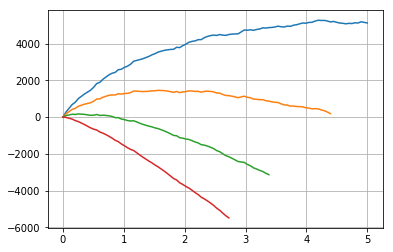

In [9]:
M = 100
p = 0.3
g = 1  # Top 1%
T = 20000
Hs = [15, 20, 25, 30]

for H in Hs:
    gs = np.linspace(0, 5, 100)
    ls = []
    for g in gs:
        l = L(M, H, p, g, T)
        if l is None:
            continue
        ls.append((g, l))
        
    xs, ys = zip(*ls)
        
    plt.plot(xs, ys)
    
    print(xs[np.argmax(np.array(ys))])

plt.grid()
plt.show()

Видно, что с повышением стоимости удержания экономический эффект становится все незначительнее вплоть до ухода в ноль

Изменим вероятность, с которой пользователь принимает предложение

0.0
0.0
1.56565656566
2.9797979798
3.53535353535


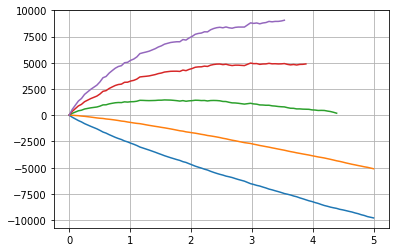

In [10]:
M = 100
H = 20
g = 1  # Top 1%
T = 20000
ps = [0.1, 0.2, 0.3, 0.4, 0.5]

for p in ps:
    gs = np.linspace(0, 5, 100)
    ls = []
    for g in gs:
        l = L(M, H, p, g, T)
        if l is None:
            continue
        ls.append((g, l))
        
    xs, ys = zip(*ls)
        
    plt.plot(xs, ys)
    
    print(xs[np.argmax(np.array(ys))])

plt.grid()
plt.show()

Видно, что с увеличением вероятности растет как экономическая выгодность кампании в целом, так и процент вовлеченных в камапнию пользователей

** Задание 4**

**Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.**

Не всегда. Например, как следует из формулы для экономического эффекта, при $p \cdot M - H < 0$ экономический эффект также отрицателен, а следовательно кампания невыгодна

** Задание 5**

**Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.**

Выпишем формулу экономической эффективности еще раз

$$
L = TP(g) \cdot (p \cdot M - H)  - p \cdot FP(g) \cdot H
$$



В ней оказались важными два параметра $TP$ и $FP$. В качестве метрики рассмотрим точность $P = TP/(TP + FP)$. 
Будем для простоты считать, что увеличивается $TP$, а это уже в свою очередь увеличивает $L$. 

In [11]:
def correct_pct(TP_, FP_, s):
    '''
    Во сколько надо увеличить TP, чтобы точность увеличилась на s%
    '''
    beta = 1 + s/100
    alpha = FP_/(FP_ + TP_*(1 - beta))
    return alpha


def L_corrected(M_, H_, p_, g_, T_, s=0):
    threshold = np.percentile(y_pred, 100 - g_)
    a = (y_pred > threshold).astype(int)

    TP = ((y == 1) & (a == 1)).sum()
    FP = ((y == 0) & (a == 1)).sum()
    TN = ((y == 0) & (a == 0)).sum()
    FN = ((y == 1) & (a == 0)).sum()
    
    alpha = correct_pct(TP, FP, s)
    TP *= alpha
    
    if not check(TP, FP, p, H, T):
        return None
    
    L = TP*(p_*M_ - H_) - p_*FP*H_
    
    return L

Пусть качество модели (точность, P) увеличилось на s=1% или 3%, тогда

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


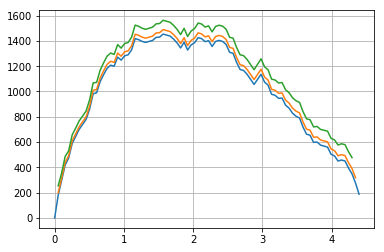

(1.5656565656565655, 1.6161616161616161, 1.6161616161616161)

In [12]:
M = 100
H = 20
p = 0.3
g = 1  # Top 1%
T = 20000

gs1 = np.linspace(0, 5, 100)
ls1 = []
ls2 = []
ls3 = []
for g in gs:
    l1 = L(M, H, p, g, T)
    if l1 is not None:
        ls1.append((g, l1))
    l2 = L_corrected(M, H, p, g, T, s=1)
    if l2 is not None:
        ls2.append((g, l2))
    l3 = L_corrected(M, H, p, g, T, s=3)
    if l3 is not None:
        ls3.append((g, l3))
    
xs1, ys1 = zip(*ls1)
xs2, ys2 = zip(*ls2)
xs3, ys3 = zip(*ls3)
    
plt.plot(xs1, ys1)
plt.plot(xs2, ys2)
plt.plot(xs3, ys3)

plt.grid()
plt.show()

xs1[np.argmax(np.array(ys1))], xs2[np.argmax(np.array(ys1))], xs3[np.argmax(np.array(ys1))]

Видим, что экономическая эффективность растет с увеличением качества модели, как и оптимальный процент участвующих в кампании 

**Задание 6**

**
Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?**

Это зависит от человековременных затрат на улучшение качества модели и должно оцениваться отдельно. Если затраты велики, то стоит оставить все как есть.

Посмотрим, насколько надо увеличить качество модели, чтобы это ощутимо (>10%) сказалось на экономическом эффекте. При выбранных значениях по умолчанию для все остальных параметров будем иметь

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


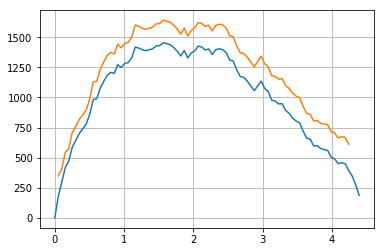

(1.5656565656565655, 1.6161616161616161)

In [13]:
M = 100
H = 20
p = 0.3
g = 1  # Top 1%
T = 20000

gs1 = np.linspace(0, 5, 100)
ls1 = []
ls2 = []
for g in gs:
    l1 = L(M, H, p, g, T)
    if l1 is not None:
        ls1.append((g, l1))
    l2 = L_corrected(M, H, p, g, T, s=5)
    if l2 is not None:
        ls2.append((g, l2))
    
xs1, ys1 = zip(*ls1)
xs2, ys2 = zip(*ls2)
    
plt.plot(xs1, ys1)
plt.plot(xs2, ys2)

plt.grid()
plt.show()

xs1[np.argmax(np.array(ys1))], xs2[np.argmax(np.array(ys1))]

Находим, что качество модели необходимо улучшить на величину порядка 5%, что в принципе вполне реально, учитывая ее текущий уровень ошибки.
Вероятно, следует вложить деньги в ее улучшение.